In [1]:
import qaoa
import qucompsys as qucs
import qutip as qu
import numpy as np
import matplotlib.pyplot as plt
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
import networkx as nx
from   networkx.generators.random_graphs import erdos_renyi_graph
import configparser
import scipy
import itertools

%matplotlib inline
%config InlineBackened.figure_format = 'svg'

# Apply QAOA for MaxCut problem, p=1 case :

##  1 Define the graph

**method_1**: define manually graphs

**method_2**: take information from files

**method_3**: generate random graph

In [2]:
def random_graph (n_nodes, prob=0.5):
    """
    This method generate a random graph, with n_nodes and at least one edge

    Parameters
    ----------
    n_nodes : int
        number of nodes of the graph.
    prob : float, optional
        probability, that two edges are linked during the creation, must be in [0, 1].
        The default is 0.5.

    Returns
    -------
    graph : Returns a $G_{n,p}$ random graph, also known as an Erdős-Rényi graph or a binomial graph
        The $G_{n,p}$ model chooses each of the possible edges with probability $p$..

    """
    graph = erdos_renyi_graph(n_nodes, prob)
    while len(list(graph.edges)) < 1:
        graph = erdos_renyi_graph(n_nodes, prob)
    return graph

In [3]:
n_nodes = 7
n_qubits = n_nodes
graph = random_graph(n_nodes)
edges = list(graph.edges)

### 1.1 plot the graph

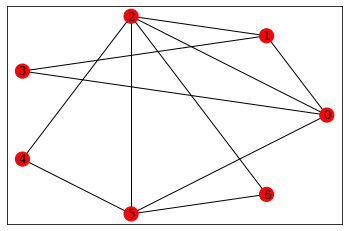

In [4]:
colors = ['r' for node in graph.nodes()]
pos = nx.circular_layout(graph)
graph_drawing = nx.draw_networkx(graph, node_color=colors, node_size=200, alpha=1, pos=pos, with_labels=True)
plt.show()

## 2 Find maximum cuts by checking all possible configurations

Define objective function
$$C(z) = \sum_{\alpha = 1}^{m}C_{\alpha}(z),$$
with $C_{\alpha} = \frac{1}{2}(z_u - z_v)$, where $\alpha = \, <u,v> \, \in \, \{<u,v>\} = E$, set of all edges 

In [5]:
def evaluate_cost_fun(configuration, edges):
    """This method evaluates the cost function of the MaxCut problem
    Parameters
        z_str : input bit string
        edges : edges of the graph
    Returns
        the integer value the cost function"""
    cost_fun = 0
    z_list = list(configuration)
    for edge in edges:
        cost_fun += (int(z_list[edge[0]])-int(z_list[edge[1]]))**2
    return cost_fun

Obtain a list of all possible configurations (as bit strings)

In [6]:
def find_maximum_cuts (n_qubits, edges):
    configurations = []
    for i in range(2**(n_qubits-1)):
        configurations.append(bin(i)[2:].zfill(n_qubits))
    dict_cuts = {}
    for config in configurations:
        dict_cuts[config] = evaluate_cost_fun(config, edges)
    max_cost_fun = max(list(dict_cuts.values()))
    maximum_cuts = []
    for key in dict_cuts.keys():
        if dict_cuts[key] == max_cost_fun:
            maximum_cuts.append(key)
    return maximum_cuts

In [7]:
find_maximum_cuts(n_qubits, edges)

['0011010']

In [8]:
a_maximum_cut = find_maximum_cuts(n_qubits, edges)[0]
max_cost_fun = evaluate_cost_fun (a_maximum_cut, edges)
max_cost_fun

9

In [9]:
configurations = list(itertools.product([0,1], repeat = n_qubits))
dict_cuts = {}
for i in range(2**(n_qubits-1)):
    dict_cuts[configurations[i]] = evaluate_cost_fun(configurations[i], edges)

In [10]:
#print frquencies of cuts 
print(np.unique(list(dict_cuts.values()), return_counts = True))

(array([0, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 1,  3,  3,  9, 11, 17, 17,  2,  1], dtype=int64))


{(0, 0, 1, 1, 0, 1, 0): 9}


(array([ 1.,  0.,  3.,  3.,  9., 11., 17., 17.,  2.,  1.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

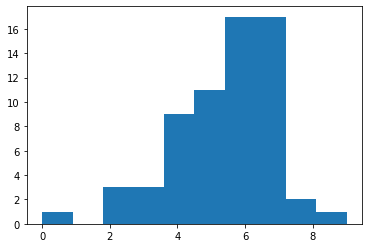

In [11]:
dict_max_cuts = dict((config, max_cut) for config, max_cut in dict_cuts.items() if max_cut == np.max(list(dict_cuts.values())))
print(dict_max_cuts)
plt.hist(dict_cuts.values())

In [12]:
list(dict_max_cuts.keys())[0]

(0, 0, 1, 1, 0, 1, 0)

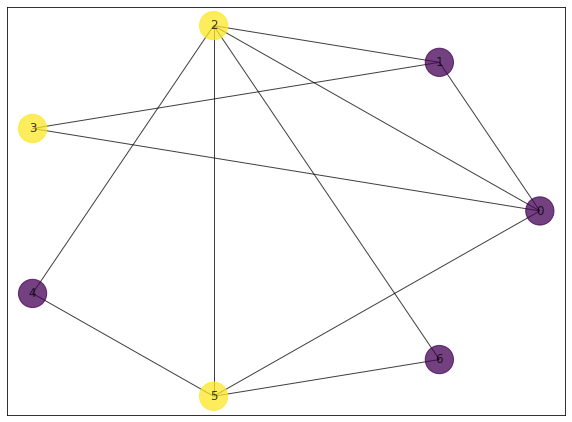

In [13]:
#print one max_cut
fig = plt.figure(figsize=(10,7.5))
colors = list(dict_max_cuts.keys())[0]
pos = nx.circular_layout(graph)
nx.draw_networkx(graph, node_color=colors, node_size=800, alpha = 0.75, pos=pos)

## 3 Parameters optimization

for p = 1 QAOA level, for MaxCut, there's a therorem that gives an analitical expression of $F_p$:

$$F_1(\gamma,\beta) = \langle C \rangle = \sum_{<u,v>} C_{<u,v>} = \sum_{<u,v>} 
\frac{1}{2} + \frac{1}{4} (sin4\beta sin2\gamma)(cos^{d_u}\gamma + cos^{d_v}\gamma) - \frac{1}{4}(sin^2\beta cos^{d_u + d_v - 2\lambda_{uv}}\gamma)(1-cos^{\lambda_{uv}}2\gamma)$$

so, for each edge $<u,v>$, we have to get:
* $d_u$: degree of vertex $u$ -1
* $d_v$: degree of vertex $v$ -1
* $\lambda_{uv}$: number common neighbours of vertices $u$ and $v$

### 3.1 define functions to get $F_1$

define function to get $d_u + 1$

In [14]:
def vertex_degree(graph, vertex_u):
    return len(graph[vertex_u])

define function to get $\lambda_{uv}$

In [15]:
def common_neighbours (graph, vertex_u, vertex_v):
    common_neigh = 0
    for vertex_w in graph[vertex_u]:
        if (vertex_w in graph[vertex_v]) and (vertex_w not in (vertex_u, vertex_v)):
            common_neigh +=1
    return common_neigh

find $F_1$ maxima

define function which evaluates $F_1(\gamma, \beta)$

In [16]:
def analitic_f_1(gamma, beta, graph, edges):
    f_1 = 0
    for edge in edges:
        degree_u = vertex_degree(graph, edge[0])
        degree_v = vertex_degree(graph, edge[1])
        lambda_uv = common_neighbours(graph, edge[0], edge[1])
        c_uv = 0.5+0.25*np.sin(4*beta)*np.sin(gamma)*(np.cos(gamma)**(degree_u-1) + np.cos(gamma)**(degree_v-1))
        -0.25*np.sin(beta)**2*np.cos(gamma)**(degree_u+degree_v-2-2*lambda_uv)*(1-np.cos(2*gamma)**lambda_uv)
        f_1 += c_uv
    return f_1

In [17]:
def minus_f_1(parameters, graph, edges):
    f_1 = 0
    gamma = parameters[0]
    beta = parameters[1]
    for edge in edges:
        degree_u = vertex_degree(graph, edge[0])
        degree_v = vertex_degree(graph, edge[1])
        lambda_uv = common_neighbours(graph, edge[0], edge[1])
        c_uv = 0.5+0.25*np.sin(4*beta)*np.sin(gamma)*(np.cos(gamma)**(degree_u-1) + np.cos(gamma)**(degree_v-1))
        -0.25*np.sin(beta)**2*np.cos(gamma)**(degree_u+degree_v-2-2*lambda_uv)*(1-np.cos(2*gamma)**lambda_uv)
        f_1 += c_uv
    return -f_1

find $(\gamma, \beta)$ which maximize $F_1$

**method 1**: Grid search for the minimizing paramenters

define grid of possible values of $(\gamma, \beta)$, with $\gamma \in [0,\pi]$ and $\beta \in [0,\pi]$ and step size = 0.1

In [18]:
step_size = 0.01
a_gamma         = np.arange(0.0, np.pi, step_size)
a_beta          = np.arange(0.0, np.pi/2, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma, a_beta, indexing='xy')

In [19]:
# Grid search for the maximizing variables
grid_f_1 = analitic_f_1(a_gamma, a_beta, graph, edges)
result = np.where(grid_f_1 == np.amax(grid_f_1))
a      = list(zip(result[0],result[1]))[0]

gamma   = a[1]*step_size
beta  = a[0]*step_size

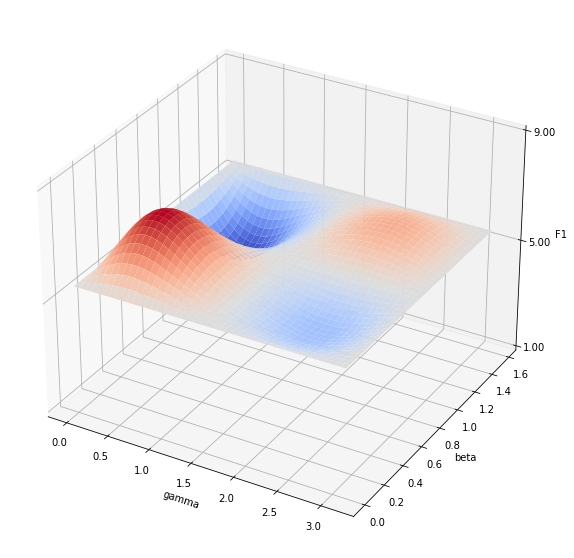


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  F_1 = 7.452
where the max_C is  9
This is attained for gamma = 0.580 and beta = 0.390


In [20]:
# Plot the expetation value grid_f_1
fig = plt.figure(figsize = (10,10))
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, grid_f_1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

a_maximum_cut = find_maximum_cuts(n_qubits, edges)[0]
max_cost_fun = evaluate_cost_fun (a_maximum_cut, edges)
max_cost_fun
ax.set_zlim(1,max_cost_fun)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_ylabel('beta')
ax.set_xlabel('gamma')
ax.set_zlabel('F1')

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  F_1 = %.03f' % np.amax(grid_f_1))
print('where the max_C is ', max_cost_fun)
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))

**method 2**: use scipy built-in function

In [21]:
scipy.optimize.minimize(minus_f_1, [0.0, 0.0], args = (graph, edges), method='Nelder-Mead')

 final_simplex: (array([[0.58104257, 0.39266981],
       [0.58098791, 0.39269406],
       [0.58112146, 0.39270628]]), array([-7.45199307, -7.45199307, -7.45199305]))
           fun: -7.451993071282114
       message: 'Optimization terminated successfully.'
          nfev: 122
           nit: 64
        status: 0
       success: True
             x: array([0.58104257, 0.39266981])

In [22]:
optimal_params = scipy.optimize.minimize(minus_f_1, [0.0, 0.0], args = (graph, edges), method='Nelder-Mead')['x']
optimal_params

optimal_gamma = optimal_params[0]
optimal_beta = optimal_params[1]

Plot function in parameaters space

### 3) evalaute final state through projective measurment on computational basis

In [23]:
# initial state (as density matrix):
init_state = qaoa.initial_state(n_qubits)
dm_init_state = qu.ket2dm(init_state)

In [24]:
# define MaxCut hamiltonian operators
mix_ham = qaoa.mix_hamilt(n_qubits)
prob_ham = qaoa.prob_hamilt(n_qubits, edges)

In [25]:
# obtain final state (as density matrix)
fin_state = qaoa.evolution_operator(n_qubits, edges, [optimal_gamma], [optimal_beta])*init_state
dm_fin_state = qu.ket2dm(fin_state)

In [41]:
fin_state

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1]], shape = (128, 1), type = ket
Qobj data =
[[-0.01117631-0.01305005j]
 [ 0.01507664-0.03476492j]
 [ 0.01666363-0.05924318j]
 [ 0.01587424-0.03246269j]
 [ 0.01507664-0.03476492j]
 [-0.00069304-0.07543023j]
 [ 0.01587424-0.03246269j]
 [-0.01380978-0.01362636j]
 [ 0.01104658-0.06456035j]
 [ 0.02279376-0.05495708j]
 [ 0.03904576-0.02761862j]
 [ 0.05535204+0.05263089j]
 [ 0.02279376-0.05495708j]
 [ 0.03680132+0.00553147j]
 [ 0.05535204+0.05263089j]
 [ 0.04987948+0.07219709j]
 [ 0.03886187-0.03668862j]
 [ 0.03807248-0.00990813j]
 [ 0.08144091+0.00801438j]
 [ 0.00162071+0.02815028j]
 [ 0.03807248-0.00990813j]
 [ 0.00838846+0.0089282j ]
 [ 0.00162071+0.02815028j]
 [-0.02028668+0.0094406j ]
 [ 0.09669521-0.02204974j]
 [ 0.11300149+0.05819977j]
 [ 0.25009643+0.02612557j]
 [ 0.07783145+0.04913867j]
 [ 0.11300149+0.05819977j]
 [ 0.10752893+0.07776596j]
 [ 0.07783145+0.04913867j]
 [ 0.02468692-0.02229629j]
 [ 0.01705154-0.0676799j

In [50]:
def comp_basis_prob_dist(qstate):
    prob_dist = []
    for component in qstate.full():
        prob_dist.append(float(abs(component))**2)
    return prob_dist

In [53]:
prob_dist_fin_state = comp_basis_prob_dist(fin_state)

In [58]:
round(sum(prob_dist_fin_state),14)

1.0

<BarContainer object of 64 artists>

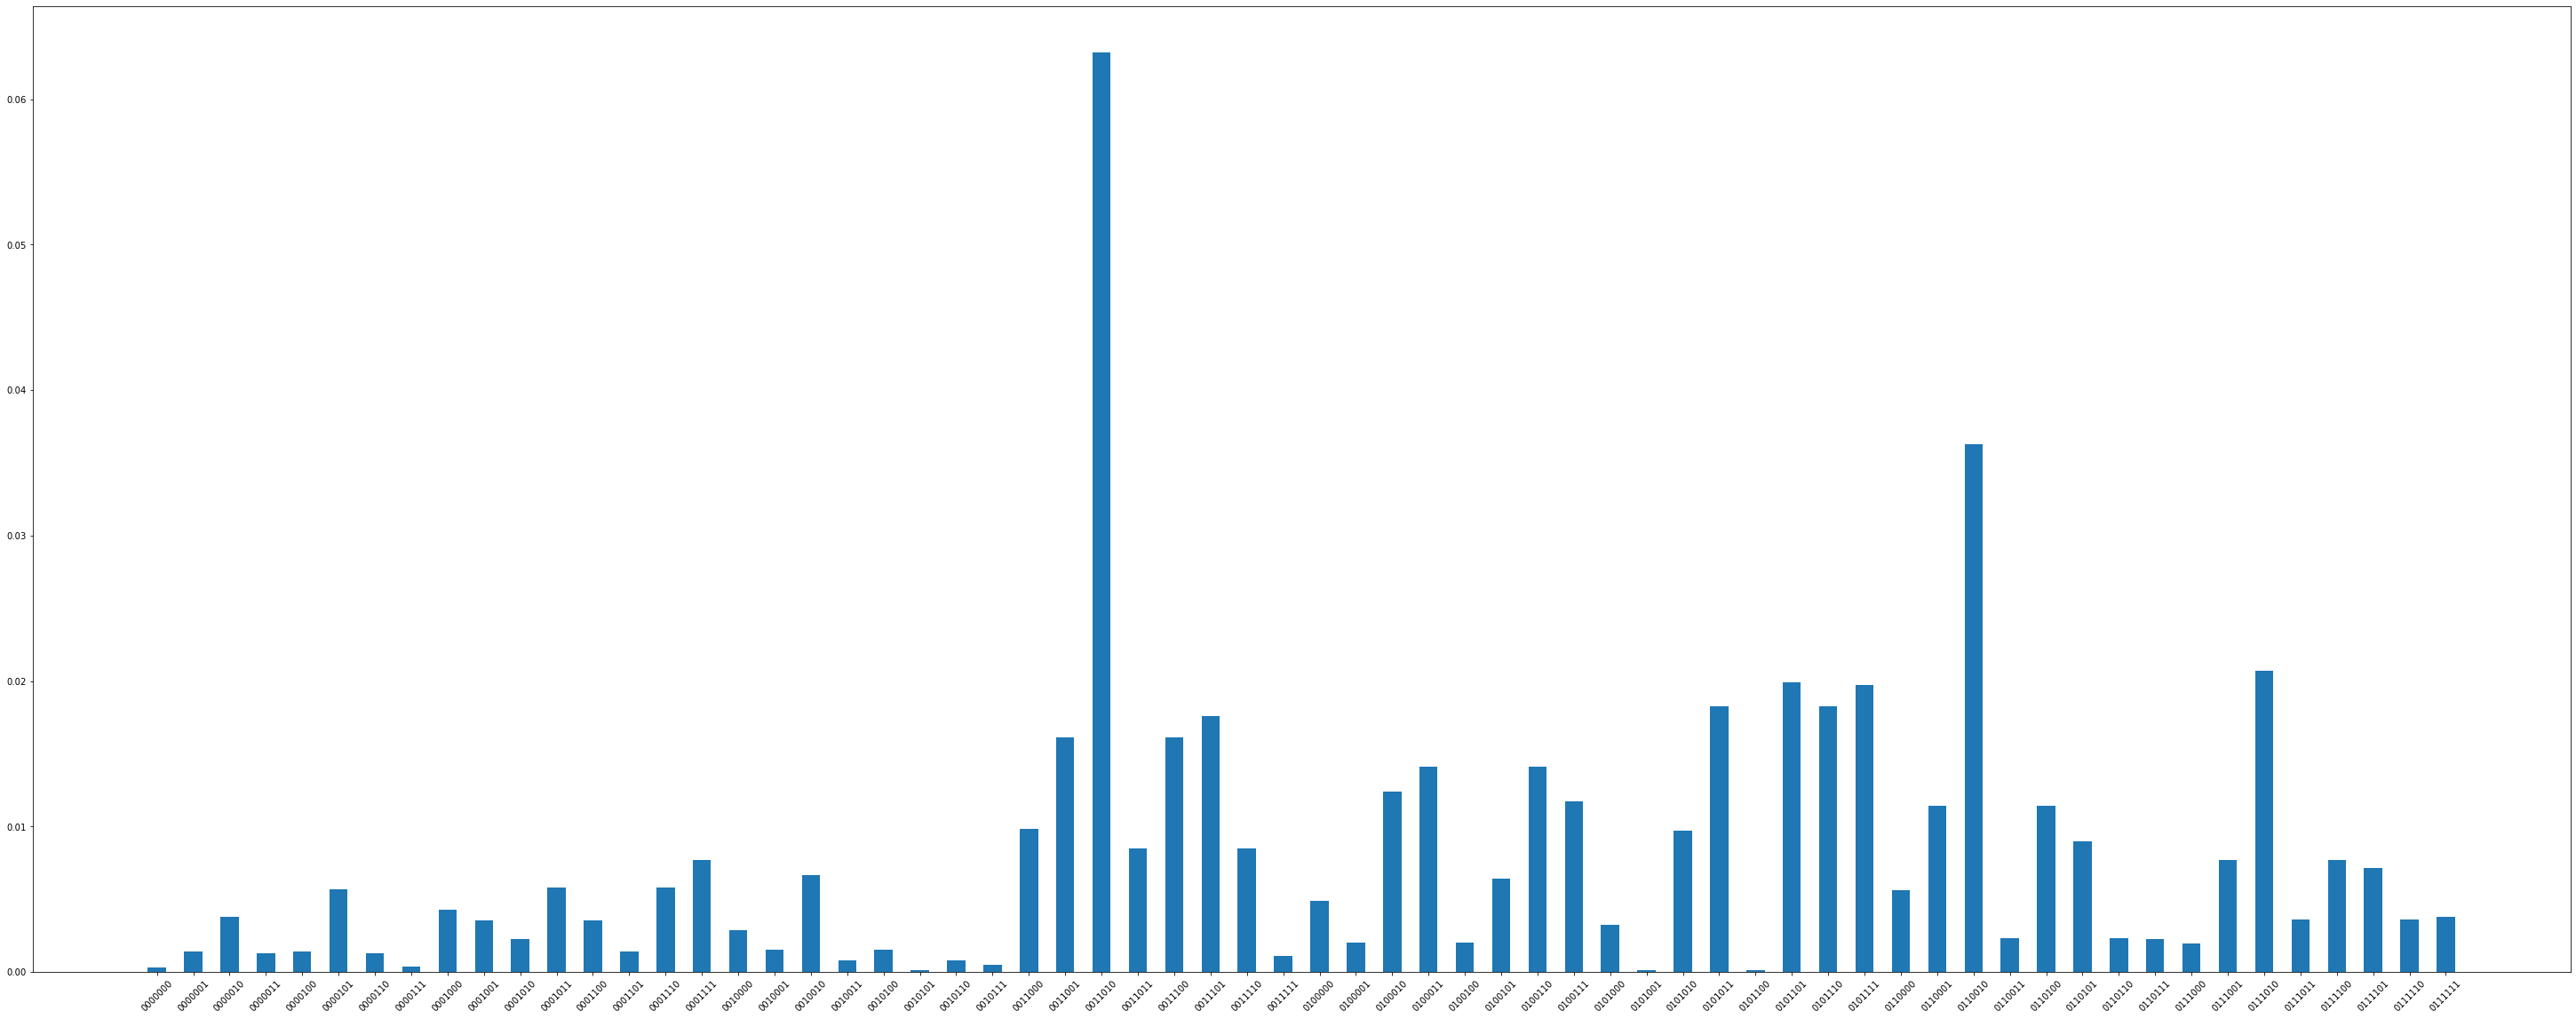

In [55]:
# plot probabilities of each state of the graph corresponding to every possible configuration after a cut (using the state)
plt.figure(figsize = (2**n_qubits/2.5,20))
plt.xticks(rotation=45)
xticks = range(0,2**(n_qubits-1))
xtick_labels = list(map(lambda x: format(x, "0"+str(n_qubits)+'b'), xticks))
plt.bar(xtick_labels,prob_dist_fin_state[:2**(n_qubits-1)],width = 0.5)

Check solutions

In [29]:
dict_prob = {}
for i in range(int(len(prob_dist_fin_state)/2)):
    dict_prob[bin(i)[2:].zfill(n_qubits)] = prob_dist_fin_state[i]

In [30]:
maximum_cuts = find_maximum_cuts(n_qubits, edges)
maximum_cuts

['0011010']

In [31]:
max_prob = sorted(list(dict_prob.values()))[-len(maximum_cuts):]

max_prob_states = []
for key in dict_prob.keys():
    for prob in max_prob:
        if dict_prob[key] == prob:
            max_prob_states.append(str(key))
            break

max_prob_states

['0011010']

In [32]:
maximum_cuts == max_prob_states

True

Test of the N measurements on single qubits of final state